In [5]:
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, f1_score, precision_score, recall_score,
                             roc_curve, auc, ConfusionMatrixDisplay)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tejas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

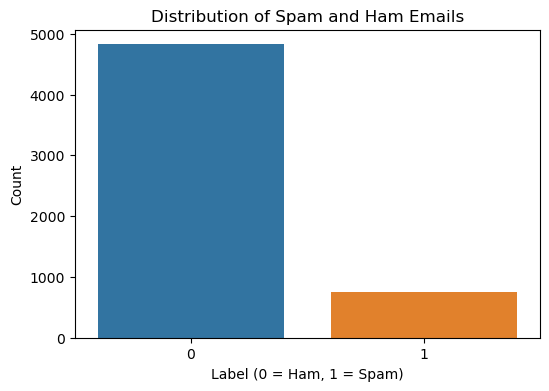

In [3]:
# 1. Load Dataset (SMS Spam Collection)
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', names=['label', 'text'])
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Plot label distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Distribution of Spam and Ham Emails")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.show()

In [6]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove special characters and lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())
    # Remove stopwords and stem
    words = [stemmer.stem(word) for word in text.split() if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(preprocess_text)

In [7]:
# 3. Feature Engineering
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [8]:
# 4. Model Training and Evaluation
def train_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = None
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    print(f"\n{model.__class__.__name__} Results:")
    print("Accuracy:", acc)
    print("F1-Score:", f1)
    print("Precision:", prec)
    print("Recall:", rec)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    return y_pred, y_prob, acc, f1, prec, rec

# Train Multinomial Naive Bayes
mnb = MultinomialNB()
mnb_pred, mnb_prob, mnb_acc, mnb_f1, mnb_prec, mnb_rec = train_evaluate(mnb, X_train_tfidf, y_train, X_test_tfidf, y_test)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr_pred, lr_prob, lr_acc, lr_f1, lr_prec, lr_rec = train_evaluate(lr, X_train_tfidf, y_train, X_test_tfidf, y_test)



MultinomialNB Results:
Accuracy: 0.9730941704035875
F1-Score: 0.8888888888888888
Precision: 0.9917355371900827
Recall: 0.8053691275167785
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.99      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Confusion Matrix:
 [[965   1]
 [ 29 120]]

LogisticRegression Results:
Accuracy: 0.9739910313901345
F1-Score: 0.8921933085501859
Precision: 1.0
Recall: 0.8053691275167785
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.89       149

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97

C:\Users\tejas\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



Best Logistic Regression Parameters: {'C': 10, 'penalty': 'l2'}


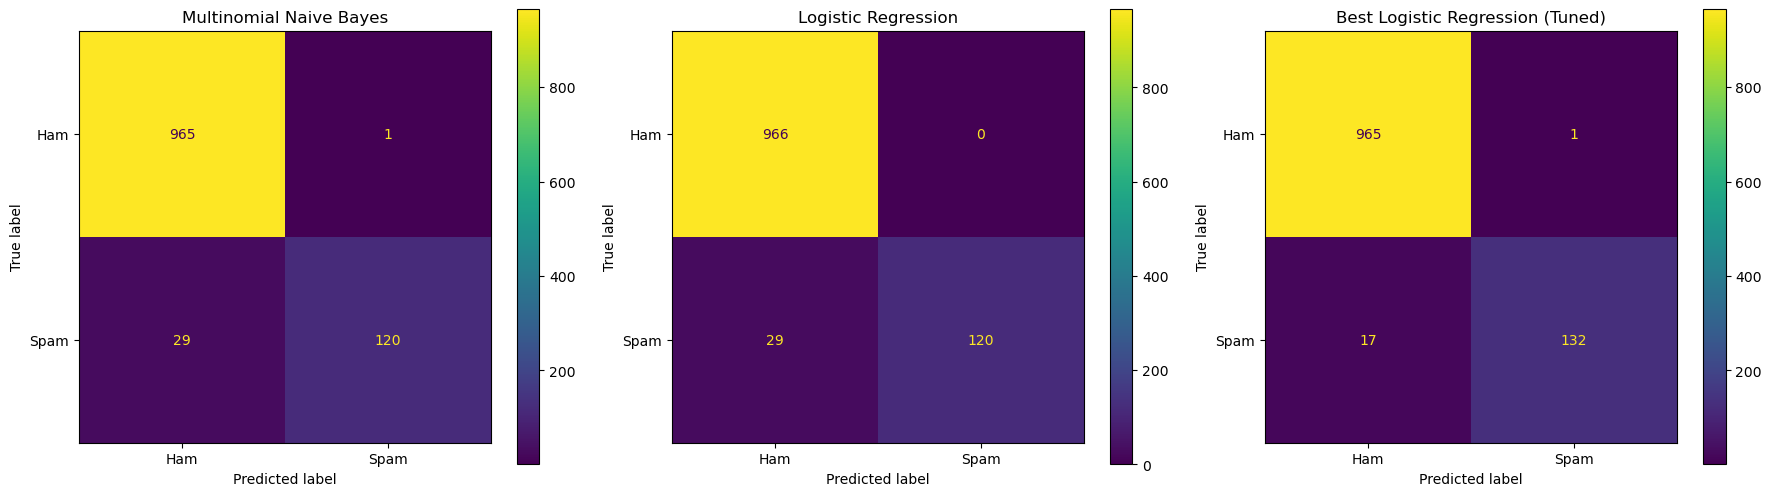

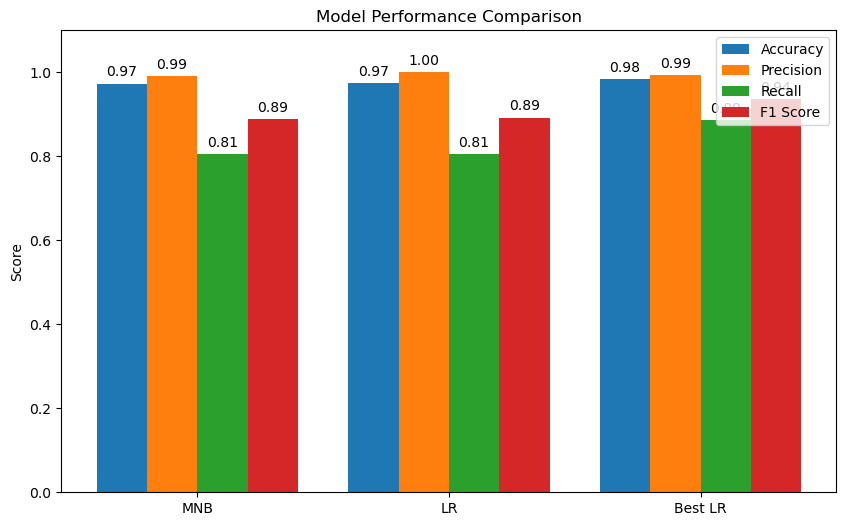

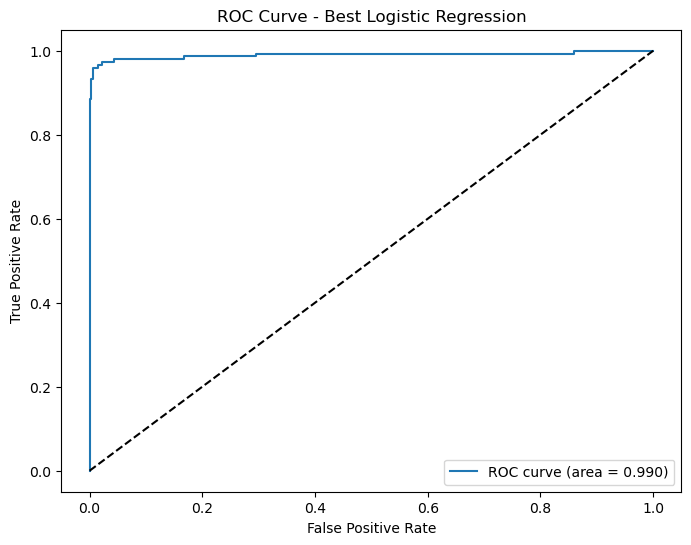

In [9]:
# 5. Hyperparameter Tuning for Logistic Regression
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)
best_lr = grid_search.best_estimator_

print("\nBest Logistic Regression Parameters:", grid_search.best_params_)

# Evaluate best Logistic Regression
best_lr_pred = best_lr.predict(X_test_tfidf)
best_lr_prob = best_lr.predict_proba(X_test_tfidf)[:, 1]

# Save Best Model and Vectorizer
joblib.dump(best_lr, 'spam_model.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# --- Visualization ---

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18,5))

ConfusionMatrixDisplay.from_predictions(y_test, mnb_pred, display_labels=['Ham', 'Spam'], ax=axes[0])
axes[0].set_title("Multinomial Naive Bayes")

ConfusionMatrixDisplay.from_predictions(y_test, lr_pred, display_labels=['Ham', 'Spam'], ax=axes[1])
axes[1].set_title("Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test, best_lr_pred, display_labels=['Ham', 'Spam'], ax=axes[2])
axes[2].set_title("Best Logistic Regression (Tuned)")

plt.tight_layout()
plt.show()

# Bar plot of metrics for the three models
models = ['MNB', 'LR', 'Best LR']
accuracy = [mnb_acc, lr_acc, accuracy_score(y_test, best_lr_pred)]
precision = [mnb_prec, lr_prec, precision_score(y_test, best_lr_pred)]
recall = [mnb_rec, lr_rec, recall_score(y_test, best_lr_pred)]
f1 = [mnb_f1, lr_f1, f1_score(y_test, best_lr_pred)]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, precision, width, label='Precision')
rects3 = ax.bar(x + 0.5*width, recall, width, label='Recall')
rects4 = ax.bar(x + 1.5*width, f1, width, label='F1 Score')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 1.1)
ax.legend()

for rects in [rects1, rects2, rects3, rects4]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()

# ROC Curve for best Logistic Regression
fpr, tpr, thresholds = roc_curve(y_test, best_lr_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best Logistic Regression')
plt.legend(loc='lower right')
plt.show()
